<a href="https://colab.research.google.com/github/Aditya-0911/Sarcasm-Detection/blob/main/Sarcasm_Detection_in_News_Headlines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Parsing Sarcasm: An AI Approach to Headline Analysis**

### **Project Description**

Sarcasm detection in news headlines is an engaging and complex task situated at the nexus of natural language processing and sentiment analysis. It plays a pivotal role in deciphering the nuanced and often context-dependent nature of sarcasm in written headlines, contributing to a deeper understanding of news content.  

Recognizing sarcasm enhances readers' comprehension of intended messages, particularly in political and cultural commentary, promotes media literacy, and aids in the discernment of genuine reporting from deceptive or misleading content. It also refines sentiment analysis, reducing the risk of erroneous sentiment polarity predictions. In an era of information overload and fake news, sarcasm detection is a crucial tool in the pursuit of accurate and informed journalism and reader engagement.

In [ ]:
# Checking for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2a04ae4c-a523-fc01-62b3-e995a599c0ff)


In [ ]:
# Adding kaggle.json for using the kaggle api
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


### **Objective**

The challenge is to develop automated methods for accurately detecting sarcasm in news headlines.

### **Dataset**

I will bw using News Headlines Dataset For Sarcasm Detection dataset which is available in [kaggle](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection)

The dataset contains two json files `Sarcasm_Headlines_Dataset.json` and `Sarcasm_Headlines_Dataset_v2.json`. I will be using the latter json as it contains more number of headlines but feel free to use any one of the json file while running this file.  

In both the json files each record has the following attributes:-  
Each record consists of three attributes:

`is_sarcastic`: 1 if the record is sarcastic otherwise 0

`headline`: the headline of the news article

`article_link`: link to the original news article. Useful in collecting supplementary data

In [ ]:
# downloading the dataset from kaggle using api
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

news-headlines-dataset-for-sarcasm-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# importing necessary libraries for this project
import zipfile
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Setting the random seed so that everytime our parameters remain fixed
tf.random.set_seed(123)

In [ ]:
# unzipping the downloaded zipfile from kaggle api
zip=zipfile.ZipFile('/content/news-headlines-dataset-for-sarcasm-detection.zip','r')
zip.extractall()
zip.close()

In [ ]:
# below function parse_data was provided by the dataset owner in kaggle about how to open the dataset
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

# I will be using V2 of the dataset but if you want to change to the otherdataset change the path below
data = list(parse_data('/content/Sarcasm_Headlines_Dataset_v2.json'))
sentences=[]
labels=[]
# I will be appending headlines and their corresponding labels in two lists
for item in data:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

total number of sarcastic lines:  13634
total number of non-sarcastic lines:  14985
total number of headlines in the dataset:  28619 



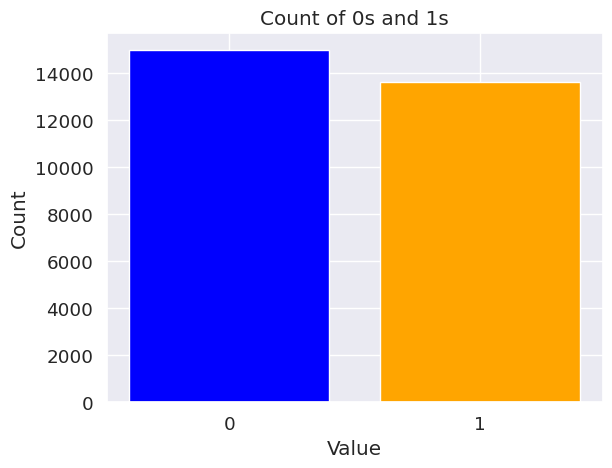

In [ ]:
# Plotting the count of sarcastic and non-sarcastic headlines
# Initialize counters for 0s and 1s
count_0 = 0
count_1 = 0

# Count the occurrences
for value in labels:
    if value == 0:
        count_0 += 1
    elif value == 1:
        count_1 += 1

# Create a bar plot to visualize the counts
values = [0, 1]
counts = [count_0, count_1]
colors = ['blue', 'orange']

print('total number of sarcastic lines: ',count_1)
print('total number of non-sarcastic lines: ',count_0)
print('total number of headlines in the dataset: ',count_1+count_0,'\n')

plt.bar(values, counts,color=colors)
plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks(values)
plt.title('Count of 0s and 1s')
plt.show()


In [ ]:
# Defining the parameters for text classification
vocab_size=10000 # Maximum vocabulary size for word representation.
embedding_dim=16 # Dimensionality of word embeddings.
max_length=32 # Maximum length of input sequences.
trunc_type='post' # Truncate sequences from the end if they exceed max_length.
padding_type='post' # Pad sequences with zeros at the end if they are shorter than max_length.
oov_token='<OOV>' # Token to represent out-of-vocabulary words.
training_size=20000 # Size of the training dataset.

In [ ]:
training_sentences=sentences[0:training_size]  # Select the first 'training_size' sentences for training.
training_labels=np.array(labels[0:training_size]) # Create training labels for the selected sentences.
testing_sentences=sentences[training_size:] # Select the remaining sentences for testing.
testing_labels=np.array(labels[training_size:]) # Create testing labels for the selected sentences.

In [ ]:
# Create a Tokenizer instance with a specified vocabulary size and out-of-vocabulary token
# Fitting the Tokenizer on training data and retriveing the word index
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index=tokenizer.word_index

# Converting training sentences into sequences mapped according to the word index
training_sequences=tokenizer.texts_to_sequences(training_sentences)

# Padding the sequences which are shorter than the max_length
padded=pad_sequences(training_sequences,padding=padding_type,maxlen=max_length,truncating=trunc_type)

# Similiarly converting testing sentences to sequences and padding them
testing_sequences=tokenizer.texts_to_sequences(testing_sentences)
testing_padded=pad_sequences(testing_sequences,padding=padding_type,maxlen=max_length,truncating=trunc_type)

### **Model 1**
- Emmbedding layer
- Global Average Pooling Layer for dimension reduction
- 2 Dense layers one with 24 nodes and other 1 node
- Using Adam optimizer with 0.001 learning rate
- Running for 30 epochs

In [ ]:
model=keras.Sequential([
    keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(24,activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
fit1=model.fit(padded,training_labels,epochs=30,validation_data=(testing_padded,testing_labels),verbose=2)

Epoch 1/30
625/625 - 23s - loss: 0.5711 - accuracy: 0.6932 - val_loss: 0.3860 - val_accuracy: 0.8365 - 23s/epoch - 37ms/step
Epoch 2/30
625/625 - 4s - loss: 0.3167 - accuracy: 0.8711 - val_loss: 0.3321 - val_accuracy: 0.8572 - 4s/epoch - 7ms/step
Epoch 3/30
625/625 - 5s - loss: 0.2402 - accuracy: 0.9076 - val_loss: 0.3314 - val_accuracy: 0.8507 - 5s/epoch - 7ms/step
Epoch 4/30
625/625 - 6s - loss: 0.1969 - accuracy: 0.9254 - val_loss: 0.3527 - val_accuracy: 0.8468 - 6s/epoch - 10ms/step
Epoch 5/30
625/625 - 4s - loss: 0.1647 - accuracy: 0.9395 - val_loss: 0.3704 - val_accuracy: 0.8472 - 4s/epoch - 7ms/step
Epoch 6/30
625/625 - 3s - loss: 0.1400 - accuracy: 0.9500 - val_loss: 0.4046 - val_accuracy: 0.8409 - 3s/epoch - 4ms/step
Epoch 7/30
625/625 - 3s - loss: 0.1216 - accuracy: 0.9581 - val_loss: 0.4438 - val_accuracy: 0.8366 - 3s/epoch - 4ms/step
Epoch 8/30
625/625 - 3s - loss: 0.1051 - accuracy: 0.9636 - val_loss: 0.4784 - val_accuracy: 0.8343 - 3s/epoch - 4ms/step
Epoch 9/30
625/625 -

In [ ]:
# defining a function for plotting all graphs in future
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

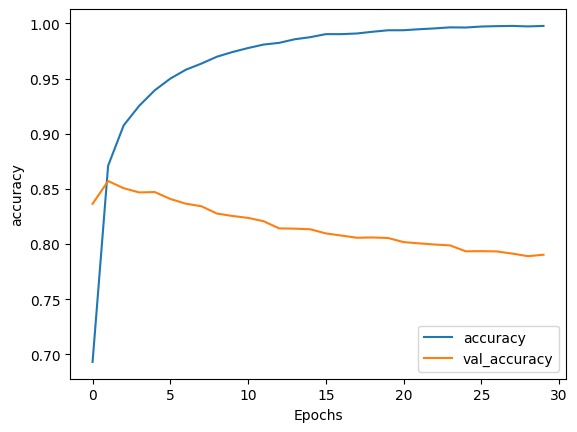

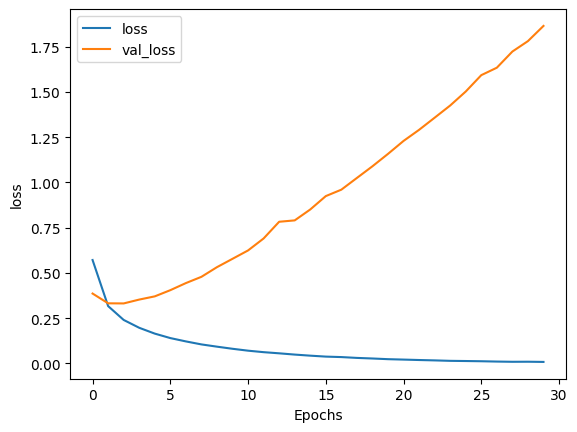

In [ ]:
# Plot the accuracy and loss history
plot_graphs(fit1, 'accuracy')
plot_graphs(fit1, 'loss')

270/270 [==============================] - 0s 1ms/step


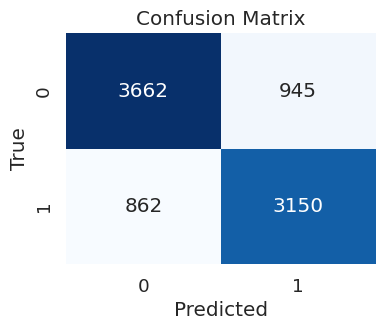

In [ ]:
# Creating a confusion matrix for the testing sequences for checking their metrics

predicted_labels=np.round(model.predict(testing_padded))
cm = metrics.confusion_matrix(predicted_labels,testing_labels)
classes=[0,1]
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
plt.figure(figsize=(4, 3))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# saving the metrics of model 1 in a list

model_f1_score=metrics.f1_score(predicted_labels,testing_labels)
model_precision=metrics.precision_score(predicted_labels,testing_labels)
model_recall=metrics.recall_score(predicted_labels,testing_labels)
model_accuracy=metrics.accuracy_score(predicted_labels,testing_labels)
model1_metrics=[model_f1_score,model_precision,model_recall,model_accuracy]
model1_metrics

[0.777106204514617, 0.7692307692307693, 0.7851445663010967, 0.7903469079939668]

### **Model 2**
- Emmbedding layer
- Global Average Pooling Layer for dimension reduction
- 1 dimesnional convolutional layer of 128 filters of 5X5 size and relu activation
- 2 Dense layers one with 24 nodes and other 1 node
- Using Adam optimizer with learing rate 0.001
- Running for 30 epochs

In [ ]:
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128,5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()
fit2=model_conv.fit(padded,training_labels,epochs=30,validation_data=(testing_padded,testing_labels),verbose=2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 16)            160000    
                                                                 
 conv1d (Conv1D)             (None, 28, 128)           10368     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 173489 (677.69 KB)
Trainable params: 173489 (677.69 KB)
Non-trainable params: 0 (0.00 Byte)
______________

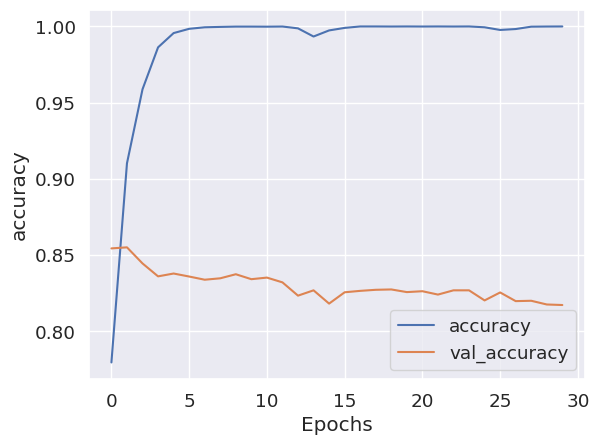

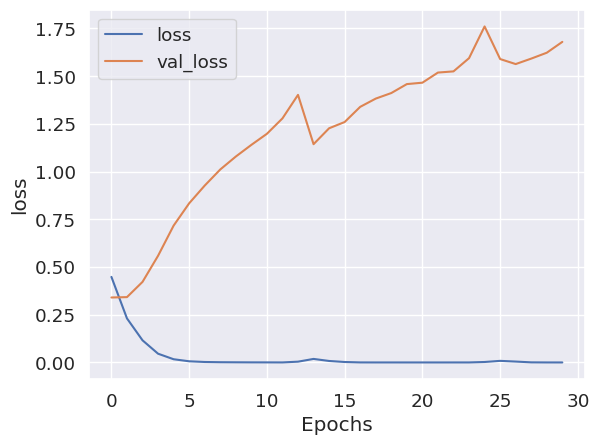

In [ ]:
# Plot the accuracy and loss history
plot_graphs(fit2, 'accuracy')
plot_graphs(fit2, 'loss')

270/270 [==============================] - 0s 2ms/step


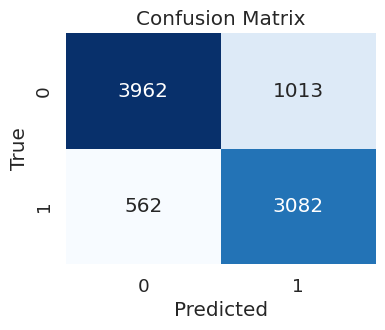

In [ ]:
# Creating a confusion matrix for the testing sequences for checking their metrics

predicted_labels=np.round(model_conv.predict(testing_padded))
cm = metrics.confusion_matrix(predicted_labels,testing_labels)
classes=[0,1]
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
plt.figure(figsize=(4, 3))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# saving the metrics of model in a list

model_f1_score=metrics.f1_score(predicted_labels,testing_labels)
model_precision=metrics.precision_score(predicted_labels,testing_labels)
model_recall=metrics.recall_score(predicted_labels,testing_labels)
model_accuracy=metrics.accuracy_score(predicted_labels,testing_labels)
model_conv_metrics=[model_f1_score,model_precision,model_recall,model_accuracy]
model_conv_metrics

[0.7964853340224834,
 0.7526251526251526,
 0.8457738748627881,
 0.8172641837800209]

### **Model 3**
- Emmbedding layer
- Global Average Pooling Layer for dimension reduction
- Bidirectional LSTM with 32 units
- 2 Dense layers one with 24 nodes and other 1 node
- Using Adam optimizer with 0.001 learning rate
- Running for 30 epochs

In [ ]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()
fit3=model_lstm.fit(padded,training_labels,epochs=30,validation_data=(testing_padded,testing_labels),verbose=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 16)            160000    
                                                                 
 bidirectional (Bidirection  (None, 64)                12544     
 al)                                                             
                                                                 
 dense_4 (Dense)             (None, 24)                1560      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 174129 (680.19 KB)
Trainable params: 174129 (680.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
625/625 - 21s - loss: 0.4133 - accuracy: 0.8011 - val_loss: 0.3116 - 

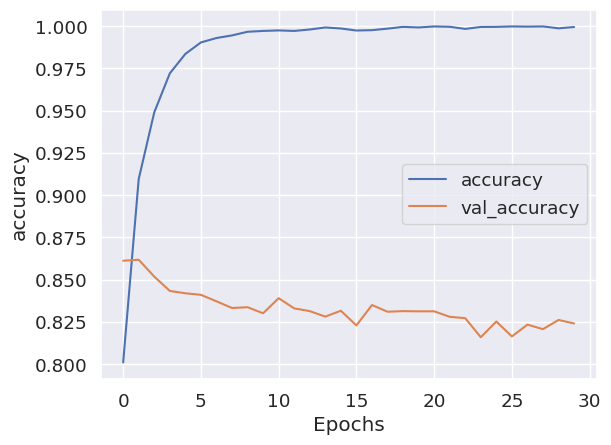

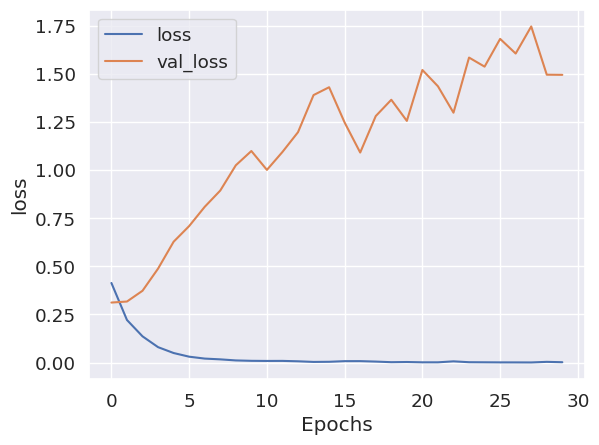

In [ ]:
# Plot the accuracy and loss history
plot_graphs(fit3, 'accuracy')
plot_graphs(fit3, 'loss')

270/270 [==============================] - 2s 4ms/step


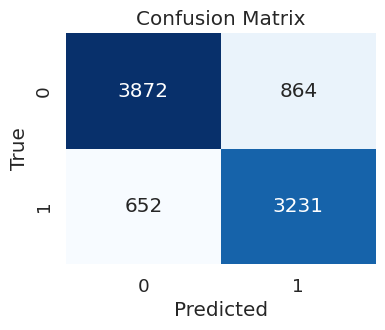

In [ ]:
# Creating a confusion matrix for the testing sequences for checking their metrics

predicted_labels=np.round(model_lstm.predict(testing_padded))
cm = metrics.confusion_matrix(predicted_labels,testing_labels)
classes=[0,1]
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
plt.figure(figsize=(4, 3))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# saving the metrics of model in a list
model_f1_score=metrics.f1_score(predicted_labels,testing_labels)
model_precision=metrics.precision_score(predicted_labels,testing_labels)
model_recall=metrics.recall_score(predicted_labels,testing_labels)
model_accuracy=metrics.accuracy_score(predicted_labels,testing_labels)
model_lstm_metrics=[model_f1_score,model_precision,model_recall,model_accuracy]
model_lstm_metrics

[0.8099774379543746, 0.789010989010989, 0.8320885912953901, 0.8241095254669916]

## **Hybrid Models**

After using CNN and LSTM separately now I am trying to combine both neural networks into one model to create a Hybrid Neural Network using CNN first and LSTM after it

### **Model 4**
- Emmbedding layer
- Global Average Pooling Layer for dimension reduction
- 1 dimesnional convolutional layer of 128 filters of 5X5 size, relu activation and same padding
- Maxpooling of ool size 2X2 and same padding
- Bidirectional LSTM with 32 units
- 2 Dense layers one with 24 nodes and other 1 node
- Using Adam optimizer with 0.001 learning rate
- Running for 30 epochs

In [ ]:
model_lstm2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128,5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(2,padding='same'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# Set the training parameters
model_lstm2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'],)

# Print the model summary
model_lstm2.summary()
fit4=model_lstm2.fit(padded,training_labels,epochs=30,validation_data=(testing_padded,testing_labels),verbose=2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 32, 16)            160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 128)           10368     
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 128)           0         
 D)                                                              
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 24)                1560      
                                                                 
 dense_7 (Dense)             (None, 1)                

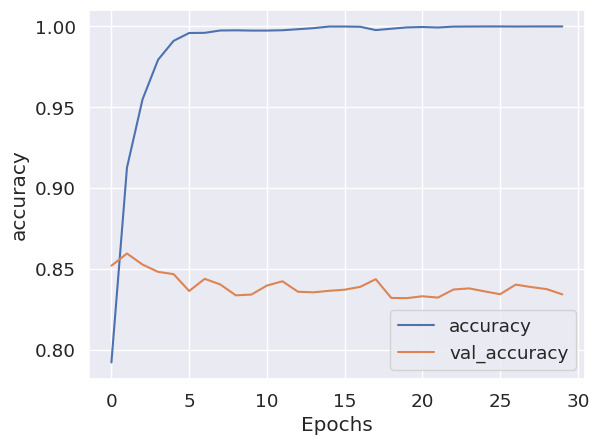

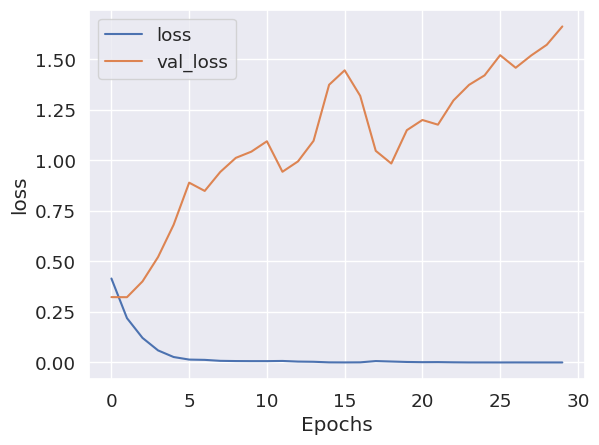

In [ ]:
# Plot the accuracy and loss history
plot_graphs(fit4, 'accuracy')
plot_graphs(fit4, 'loss')

270/270 [==============================] - 1s 3ms/step


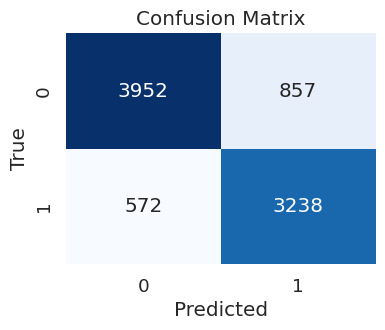

In [ ]:
# Creating a confusion matrix for the testing sequences for checking their metrics
predicted_labels=np.round(model_lstm2.predict(testing_padded))
cm = metrics.confusion_matrix(predicted_labels,testing_labels)
classes=[0,1]
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
plt.figure(figsize=(4, 3))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# saving the metrics of model in a list
model_f1_score=metrics.f1_score(predicted_labels,testing_labels)
model_precision=metrics.precision_score(predicted_labels,testing_labels)
model_recall=metrics.recall_score(predicted_labels,testing_labels)
model_accuracy=metrics.accuracy_score(predicted_labels,testing_labels)
model_lstm2_metrics=[model_f1_score,model_precision,model_recall,model_accuracy]
model_lstm2_metrics

[0.8192283364958887,
 0.7907203907203907,
 0.8498687664041995,
 0.8342035038867618]

### **Regularization**

All the previous models have been overfitted on the training data with accuracy of 99% on training but only 80% on testing data.  

To overcome this overfitting of data I have added L2
Regularization in layers of neural network one by one to fit the data properly and learning rate decay in optimizer  

The formula for L2 Regularization  

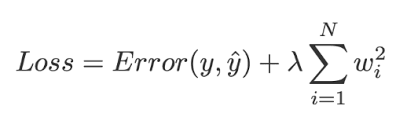

The formula for learining rate decay  

![lr decay](https://i0.wp.com/theailearner.com/wp-content/uploads/2019/07/timelr.png?resize=413%2C78&ssl=1)

### **Model 5**
- Emmbedding layer
- Global Average Pooling Layer for dimension reduction
- 1 dimesnional convolutional layer of 128 filters of 5X5 size, relu activation and same padding
- Maxpooling of ool size 2X2 and same padding
- Bidirectional LSTM with 32 units and L2 norm with &lambda; = 0.0001
- 2 Dense layers one with 24 nodes and other 1 node and L2 norm with &lambda; = 0.0001
- Using Adam optimizer with 0.01 learning rate with weight decay of rate of 0.9
- Running for 30 epochs

In [ ]:
model_lstm3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128,5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(2,padding='same'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_regularizer=tf.keras.regularizers.l2(0.0001))),
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# Set the training parameters
model_lstm3.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.01,weight_decay=0.9),metrics=['accuracy'],)

# Print the model summary
model_lstm3.summary()
fit5=model_lstm3.fit(padded,training_labels,epochs=30,validation_data=(testing_padded,testing_labels),verbose=2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 32, 16)            160000    
                                                                 
 conv1d_2 (Conv1D)           (None, 32, 128)           10368     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 16, 128)           0         
 g1D)                                                            
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 24)                1560      
                                                                 
 dense_9 (Dense)             (None, 1)                

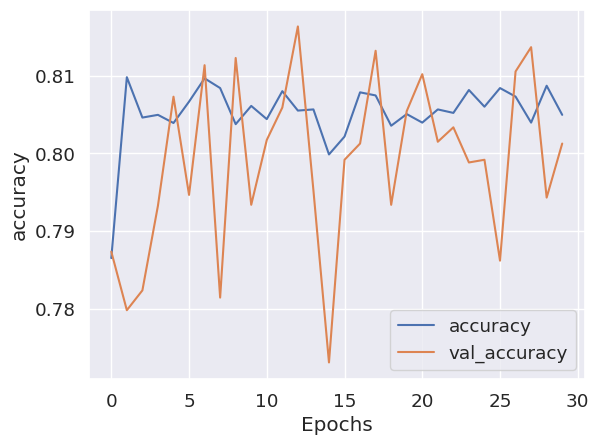

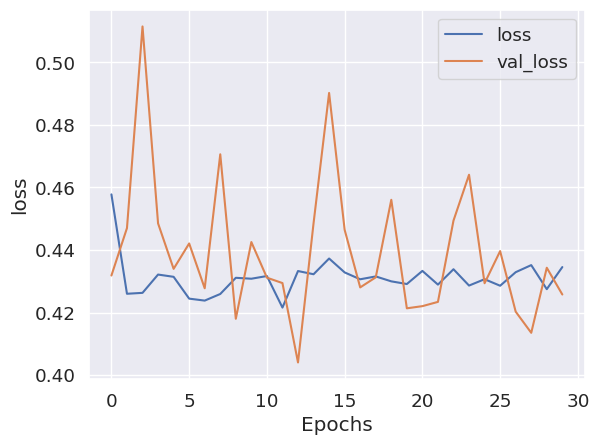

In [ ]:
# Plot the accuracy and loss history
plot_graphs(fit5, 'accuracy')
plot_graphs(fit5, 'loss')

270/270 [==============================] - 1s 3ms/step


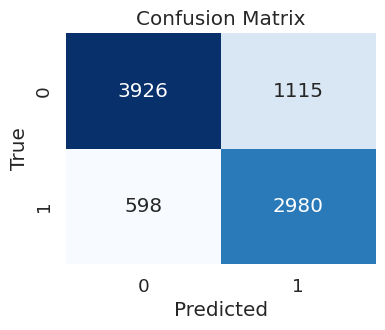

In [ ]:
# Creating a confusion matrix for the testing sequences for checking their metrics
predicted_labels=np.round(model_lstm3.predict(testing_padded))
cm = metrics.confusion_matrix(predicted_labels,testing_labels)
classes=[0,1]
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
plt.figure(figsize=(4, 3))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# saving the metrics of model in a list
model_f1_score=metrics.f1_score(predicted_labels,testing_labels)
model_precision=metrics.precision_score(predicted_labels,testing_labels)
model_recall=metrics.recall_score(predicted_labels,testing_labels)
model_accuracy=metrics.accuracy_score(predicted_labels,testing_labels)
model_lstm3_metrics=[model_f1_score,model_precision,model_recall,model_accuracy]
model_lstm3_metrics

[0.776749641600417, 0.7277167277167277, 0.8328675237562885, 0.801253045596937]

### **Model 6**
- Emmbedding layer
- Global Average Pooling Layer for dimension reduction
- 1 dimesnional convolutional layer of 128 filters of 5X5 size, relu activation and same padding
- Maxpooling of ool size 2X2 and same padding
- 2 Bidirectional LSTM with 16 units and L2 norm with &lambda; = 0.0001
- 3 Dense layers one with 12,12 and 1 nodes each and L2 norm with &lambda; = 0.0001
- Using Adam optimizer with 0.01 learning rate with weight decay of rate of 0.9
- Running for 30 epochs

In [ ]:
model_lstm4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128,5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(2,padding='same'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, kernel_regularizer=tf.keras.regularizers.l2(0.0001),return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, kernel_regularizer=tf.keras.regularizers.l2(0.0001))),
    tf.keras.layers.Dense(12, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(12, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# Set the training parameters
model_lstm4.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.01,weight_decay=0.9),metrics=['accuracy'],)

# Print the model summary
model_lstm4.summary()
fit6=model_lstm4.fit(padded,training_labels,epochs=30,validation_data=(testing_padded,testing_labels),verbose=2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 32, 16)            160000    
                                                                 
 conv1d_3 (Conv1D)           (None, 32, 128)           10368     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 16, 128)           0         
 g1D)                                                            
                                                                 
 bidirectional_3 (Bidirecti  (None, 16, 32)            18560     
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 32)                6272      
 onal)                                                           
                                                      

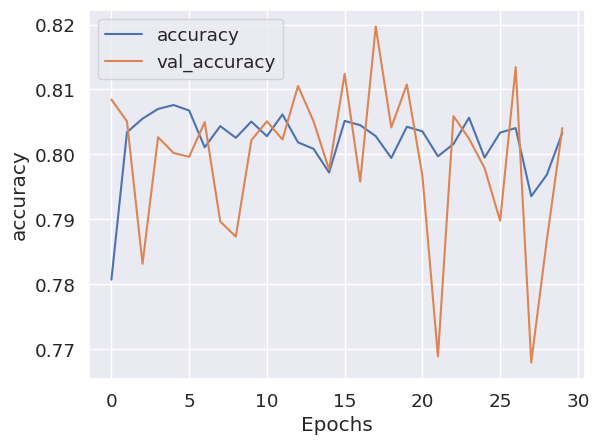

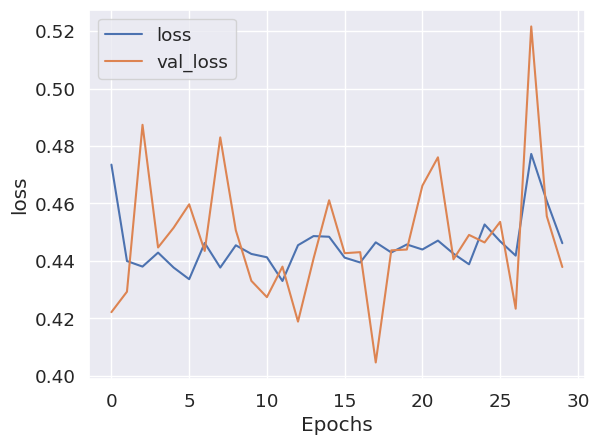

In [ ]:
# Plot the accuracy and loss history
plot_graphs(fit6, 'accuracy')
plot_graphs(fit6, 'loss')

270/270 [==============================] - 3s 4ms/step


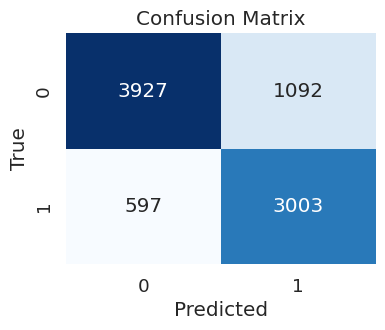

In [ ]:
# Creating a confusion matrix for the testing sequences for checking their metrics
predicted_labels=np.round(model_lstm4.predict(testing_padded))
cm = metrics.confusion_matrix(predicted_labels,testing_labels)
classes=[0,1]
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
plt.figure(figsize=(4, 3))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# saving the metrics of model in a list
model_f1_score=metrics.f1_score(predicted_labels,testing_labels)
model_precision=metrics.precision_score(predicted_labels,testing_labels)
model_recall=metrics.recall_score(predicted_labels,testing_labels)
model_accuracy=metrics.accuracy_score(predicted_labels,testing_labels)
model_lstm4_metrics=[model_f1_score,model_precision,model_recall,model_accuracy]
model_lstm4_metrics

[0.7805068226120857,
 0.7333333333333333,
 0.8341666666666666,
 0.8040375913679081]

### **Model 7**
- Emmbedding layer
- Global Average Pooling Layer for dimension reduction
- 1 dimesnional convolutional layer of 64 filters of 5X5 size, relu activation and same padding
- Maxpooling of ool size 2X2 and same padding
- 1 dimesnional convolutional layer of 64 filters of 5X5 size, relu activation and same padding
- Maxpooling of ool size 2X2 and same padding
- 2 Bidirectional LSTM with 16 units and L2 norm with &lambda; = 0.0001
- 3 Dense layers one with 12,12 and 1 nodes each and L2 norm with &lambda; = 0.0001
- Using Adam optimizer with 0.01 learning rate with weight decay of rate of 0.9
- Running for 30 epochs

In [ ]:
model_lstm5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(64,5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(2,padding='same'),
    tf.keras.layers.Conv1D(64,3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(2,padding='same'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, kernel_regularizer=tf.keras.regularizers.l2(0.0001),return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, kernel_regularizer=tf.keras.regularizers.l2(0.0001))),
    tf.keras.layers.Dense(12, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(12, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# Set the training parameters
model_lstm5.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.01,weight_decay=0.9),metrics=['accuracy'],)

# Print the model summary
model_lstm5.summary()
fit7=model_lstm5.fit(padded,training_labels,epochs=30,validation_data=(testing_padded,testing_labels),verbose=2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 32, 16)            160000    
                                                                 
 conv1d_4 (Conv1D)           (None, 32, 64)            5184      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 16, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 16, 64)            12352     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 8, 64)             0         
 g1D)                                                            
                                                                 
 bidirectional_5 (Bidirecti  (None, 8, 32)            

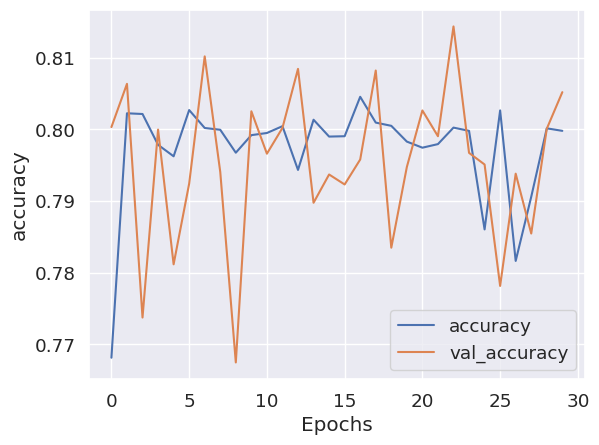

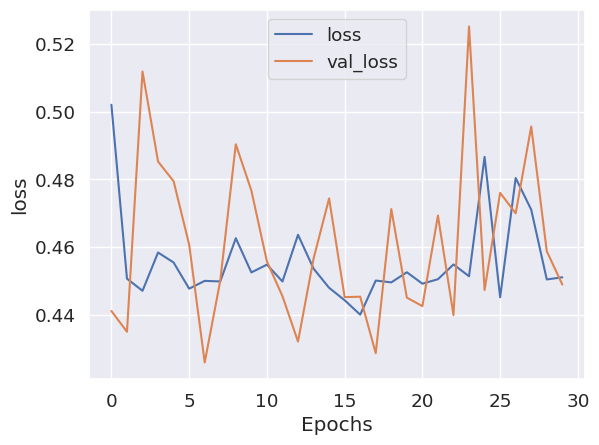

In [ ]:
# Plot the accuracy and loss history
plot_graphs(fit7, 'accuracy')
plot_graphs(fit7, 'loss')

270/270 [==============================] - 2s 4ms/step


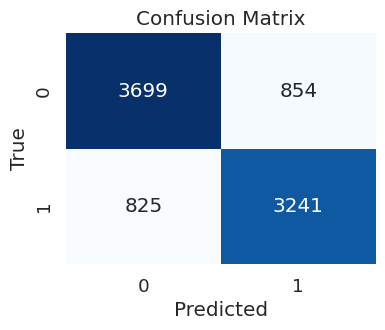

In [ ]:
# Creating a confusion matrix for the testing sequences for checking their metrics
predicted_labels=np.round(model_lstm5.predict(testing_padded))
cm = metrics.confusion_matrix(predicted_labels,testing_labels)
classes=[0,1]
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
plt.figure(figsize=(4, 3))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# saving the metrics of model in a list
model_f1_score=metrics.f1_score(predicted_labels,testing_labels)
model_precision=metrics.precision_score(predicted_labels,testing_labels)
model_recall=metrics.recall_score(predicted_labels,testing_labels)
model_accuracy=metrics.accuracy_score(predicted_labels,testing_labels)
model_lstm5_metrics=[model_f1_score,model_precision,model_recall,model_accuracy]
model_lstm5_metrics

[0.7942654086509007,
 0.7914529914529914,
 0.7970978848991638,
 0.8051978187724794]

In [ ]:
# creating a array to store all metrics together
data=np.array([model1_metrics,model_conv_metrics,model_lstm_metrics,
              model_lstm2_metrics,model_lstm3_metrics,model_lstm4_metrics,
               model_lstm5_metrics])

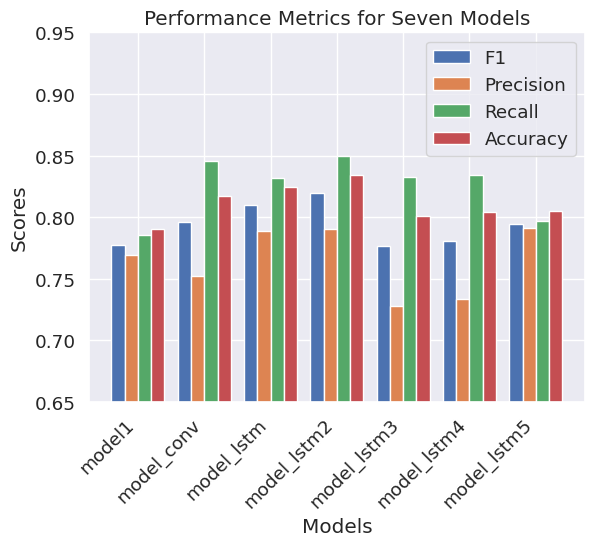

In [ ]:
# Plotting all the metrics for all models

# Create labels for each model
labels = ['model1', 'model_conv', 'model_lstm', 'model_lstm2', 'model_lstm3', 'model_lstm4', 'model_lstm5']

# Create a figure and a set of subplots (in this case, just one plot)
fig, ax = plt.subplots()

# Set the width of the bars
width = 0.2

# Define x positions for the bars (each set of four elements)
x = np.arange(len(labels))

# Create the bar plots for each metric (F1, Precision, Recall, Accuracy)
for i in range(4):
    ax.bar(x + (i * width), data[:, i], width, label=['F1', 'Precision', 'Recall', 'Accuracy'][i])

# Set axis labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics for Seven Models')

# Set x-axis ticks and labels with rotation for better readability
ax.set_xticks(x + (1.5 * width))
ax.set_xticklabels(labels, rotation=45, ha='right')

# Set y-axis lower limit to 0.6
ax.set_ylim(0.65, 0.95)  # Adjust the upper limit (1.0) as needed

# Add a legend
ax.legend()

# Show the plot
plt.show()

### **Conclusion**

- There is increase in accuracy of models if we move from ANN to CNN and then LSTM models.
- Hybrid Model i.e. Model_lstm2 has the highest accuracy among all non regularized models
- Regularizing the models and distributing the nodes in multiple layers i.e. using 2 16 units LSTM layers rather than using 1 32 unit LSTM layer has significant impact

- Although Regularization reduces the accuracy but it makes the model better overall and in the last model with distributed units and regularization we can see all metrics are nearly equal

- All metrics been nearly equal in the last models shows that the last model is providing balanced performance across different aspects of classification and is likely to be generalizing well to unseen data,  very well tuned and need only more data to increase the accuracy

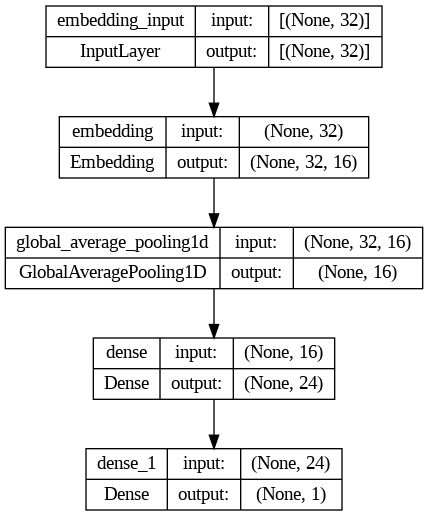

In [ ]:
# Plotting architecture of model 1
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

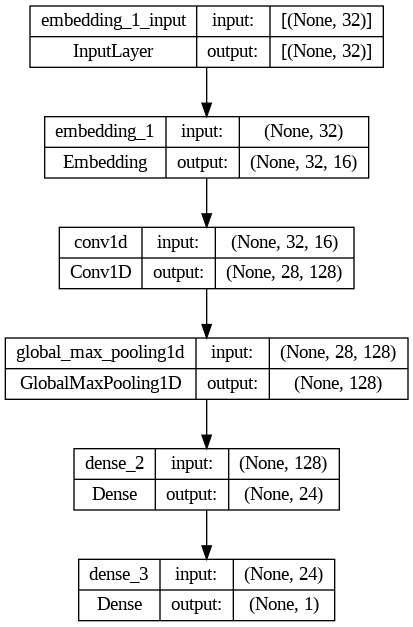

In [ ]:
# Plotting architecture of model_conv
plot_model(model_conv, to_file='model_conv_plot.png', show_shapes=True, show_layer_names=True)

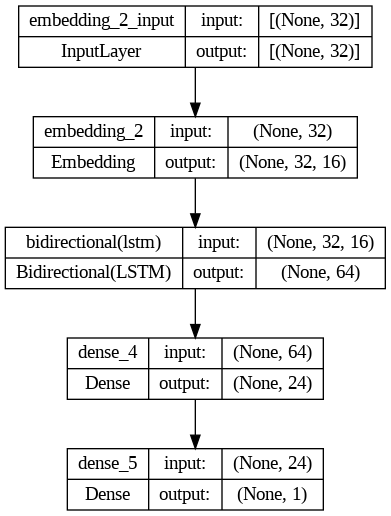

In [ ]:
# Plotting architecture of model_lstm
plot_model(model_lstm, to_file='model_lstm_plot.png', show_shapes=True, show_layer_names=True)

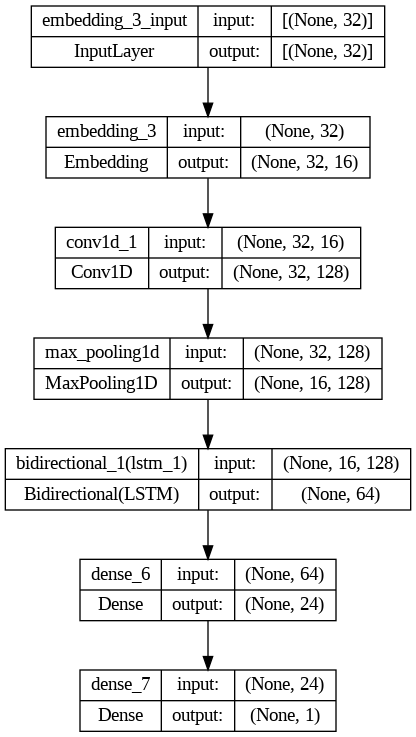

In [ ]:
# Plotting architecture of model_lstm2
plot_model(model_lstm2, to_file='model_lstm2_plot.png', show_shapes=True, show_layer_names=True)

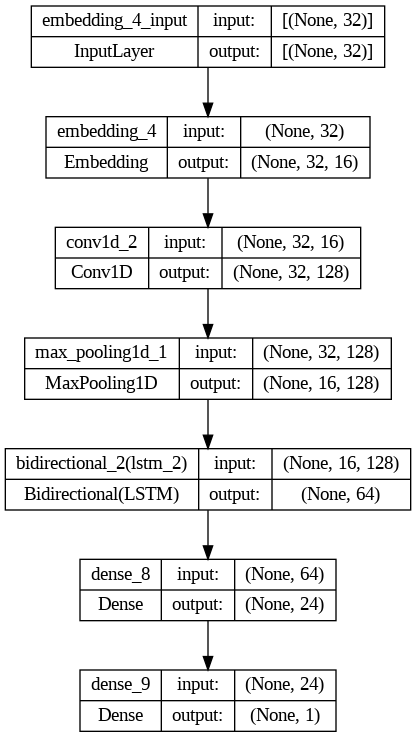

In [ ]:
# Plotting architecture of model_lstm3
plot_model(model_lstm3, to_file='model_lstm3_plot.png', show_shapes=True, show_layer_names=True)

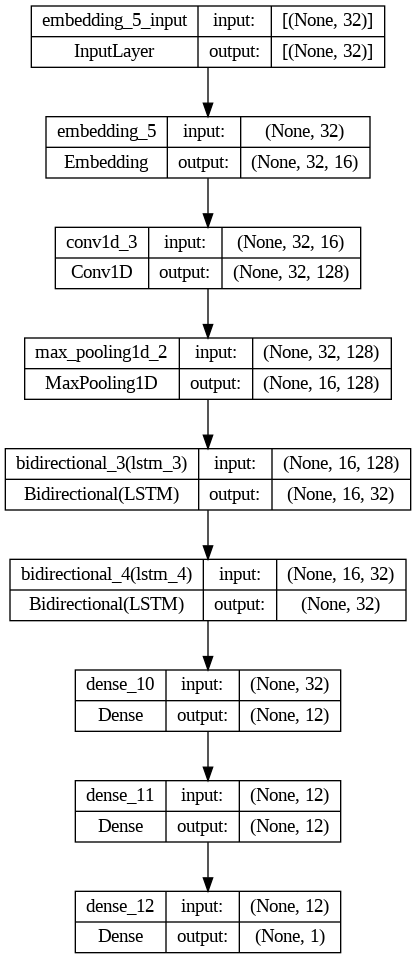

In [ ]:
# Plotting architecture of model_lstm4
plot_model(model_lstm4, to_file='model_lstm4_plot.png', show_shapes=True, show_layer_names=True)

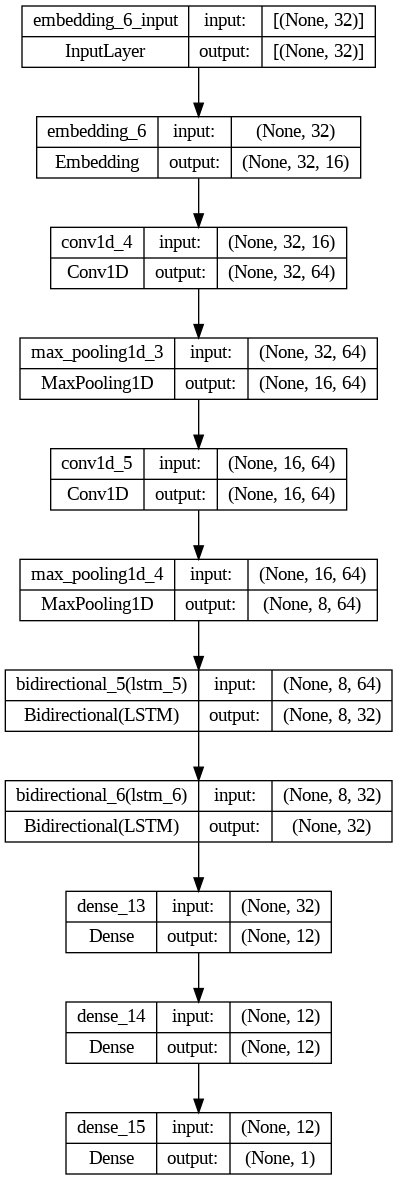

In [ ]:
# Plotting architecture of model_lstm5
plot_model(model_lstm5, to_file='model_lstm5_plot.png', show_shapes=True, show_layer_names=True)